<a href="https://colab.research.google.com/github/hyunku/NLP-Basic/blob/main/11_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%9D%98%EC%8B%A0%EA%B2%BD%EB%A7%9D%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경설정

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234,
    # number of vocab : 단어사전의 크기
    "n_vocab": 32007,
    # number of input sequence : 입력 피처 수
    "n_seq": 67,
    # hidden size : 단어 벡터의 깊이, 통상 128, 256 등으로 지정
    "d_model": 128,
    # number of output
    "n_out": 2
}
args = argparse.Namespace(**args)

print(args)

Namespace(d_model=128, n_out=2, n_seq=67, n_vocab=32007, seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

# 1.Data 준비

착안 사항 : 데이터 탐색을 통해서 입력 sentece 토큰의 길이를 얼마로 할 것인지 n_seq를 결정

In [ ]:
# 입력 문장
sentences = [
    "신차 정말 좋아요",
    "신차 속도감 너무 안좋아",
    "신차 디자인 연비 좋아요",
    "신차 엉터리로 개발했네요"
]

# 출력 정답
targets = [1, 0, 1, 0]  # 부정(0), 긍정(1)

In [ ]:
# 처리할 text 데이터 준비
pd.DataFrame(sentences, targets)

,0
1,신차 정말 좋아요
0,신차 속도감 너무 안좋아
1,신차 디자인 연비 좋아요
0,신차 엉터리로 개발했네요


In [ ]:
id_to_label = {0: "부정", 1: "긍정"}

In [ ]:
train_sentences = sentences[:2]
train_targets = targets[:2]

train_sentences, train_targets

(['신차 정말 좋아요', '신차 속도감 너무 안좋아'], [1, 0])

In [ ]:
valid_sentences = sentences[2:3]
valid_targets = targets[2:3]

valid_sentences, valid_targets

(['신차 디자인 연비 좋아요'], [1])

In [ ]:
test_sentences = sentences[3:]
test_targets = targets[3:]

test_sentences, test_targets

(['신차 엉터리로 개발했네요'], [0])

In [ ]:
# 입력 단위 토큰 수
args.n_seq = 4

# 2.Vocabulary

착안사항 : 단어사전을 통해서 n_vocab 사이즈 결정

In [ ]:
words = []

for line in sentences:
    for w in line.split():
        words.append(w)
words

['신차',
 '정말',
 '좋아요',
 '신차',
 '속도감',
 '너무',
 '안좋아',
 '신차',
 '디자인',
 '연비',
 '좋아요',
 '신차',
 '엉터리로',
 '개발했네요']

In [ ]:
words = list(dict.fromkeys(words))
words

['신차', '정말', '좋아요', '속도감', '너무', '안좋아', '디자인', '연비', '엉터리로', '개발했네요']

In [ ]:
word_to_id = {"[PAD]": 0, "[UNK]": 1}
for w in words:
    if w not in word_to_id:
        word_to_id[w] = len(word_to_id)
word_to_id

{'[PAD]': 0,
 '[UNK]': 1,
 '개발했네요': 11,
 '너무': 6,
 '디자인': 8,
 '속도감': 5,
 '신차': 2,
 '안좋아': 7,
 '엉터리로': 10,
 '연비': 9,
 '정말': 3,
 '좋아요': 4}

In [ ]:
id_to_word = {_id:w for w, _id in word_to_id.items()}
id_to_word

{0: '[PAD]',
 1: '[UNK]',
 2: '신차',
 3: '정말',
 4: '좋아요',
 5: '속도감',
 6: '너무',
 7: '안좋아',
 8: '디자인',
 9: '연비',
 10: '엉터리로',
 11: '개발했네요'}

In [ ]:
args.n_vocab = len(word_to_id)
args

Namespace(d_model=128, n_out=2, n_seq=4, n_vocab=12, seed=1234)

# 3.Train, Valid, Test 데이터 생성

In [ ]:
def make_data(sentences, targets, n_seq=4):
    inputs, labels = [], []

    for sentence, target in zip(sentences, targets):
        print(sentence, target)
        _input = [word_to_id[w] for w in sentence.split()]
        print(_input)
        _input = _input[:n_seq]
        _input += [0] * (n_seq - len(_input))
        print(_input)
        inputs.append(_input)

        _label = target
        labels.append(_label)

    inputs = np.array(inputs)
    labels = np.array(labels)

    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(train_sentences, train_targets)
train_inputs, train_labels

신차 정말 좋아요 1
[2, 3, 4]
[2, 3, 4, 0]
신차 속도감 너무 안좋아 0
[2, 5, 6, 7]
[2, 5, 6, 7]


(array([[2, 3, 4, 0],
        [2, 5, 6, 7]]), array([1, 0]))

In [ ]:
train_inputs.shape, train_labels.shape

((2, 4), (2,))

In [ ]:
valid_inputs, valid_labels = make_data(valid_sentences, valid_targets)
valid_inputs, valid_labels

신차 디자인 연비 좋아요 1
[2, 8, 9, 4]
[2, 8, 9, 4]


(array([[2, 8, 9, 4]]), array([1]))

In [ ]:
test_inputs, test_labels = make_data(test_sentences, test_targets)
test_inputs, test_labels

신차 엉터리로 개발했네요 0
[2, 10, 11]
[2, 10, 11, 0]


(array([[ 2, 10, 11,  0]]), array([0]))

In [ ]:
# d_model 단어벡터의 subword 3차원 깊이(통상 128, 256),
# n_out 출력변수, n_seq 입력피쳐(하나의 센텐스 입력 토큰수 max), n_vocab 단어사전 길이
args.n_seq = 4
args.d_model = 5
args

Namespace(d_model=5, n_out=2, n_seq=4, n_vocab=12, seed=1234)

# 4.Modeling

In [ ]:
def build_model(args):
    """
    동작만 하는 간단한 모델
    :param args: input args
    """
    inputs = tf.keras.layers.Input((args.n_seq,))  # (bs, n_seq)
    # 가. 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)  # (bs, n_seq, d_model)
    ########################################################
    # RNN, CNN, Attention, Dense ...
    ########################################################
    # 나. 문장의 특징 추출
    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden = pool(hidden)
    # 다. 단어의 vector를 이용해서 정답 확률값 예측
    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    outputs = linear(hidden)  # (bs, n_seq, n_out)
    # 라. 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

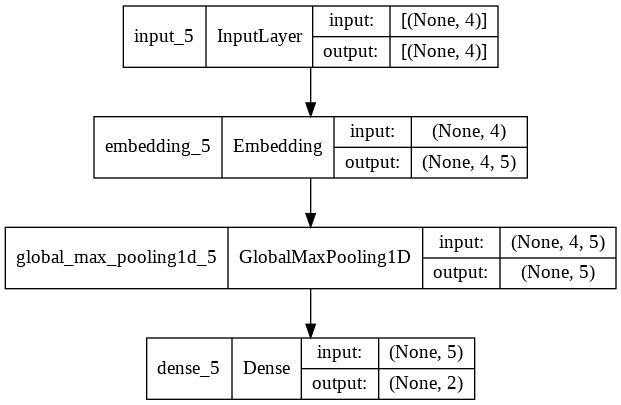

In [ ]:
# 모델 생성
model = build_model(args)
# 모델 내용 그래프 출력, none 부분은 입력 데이터 수 즉, bach size 로 생각
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# 모델링 이해*

In [ ]:
args

Namespace(d_model=5, n_out=2, n_seq=4, n_vocab=12, seed=1234)

In [ ]:
# 가. 입력 단어를 vector로 변환
embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
array([[[ 0.02343402, -0.01074823,  0.01522658, -0.04609389,
         -0.04044588],
        [-0.02594056, -0.03957871, -0.04964957,  0.02257201,
         -0.0427069 ],
        [ 0.00367712,  0.00880659,  0.04546959,  0.04229597,
         -0.03289993],
        [ 0.04099175,  0.01676757, -0.03006136, -0.01715951,
         -0.04548226]],

       [[ 0.02343402, -0.01074823,  0.01522658, -0.04609389,
         -0.04044588],
        [-0.00211576, -0.01116402,  0.00370605,  0.03210983,
          0.02358914],
        [-0.02757563, -0.03303362,  0.00482216,  0.01016521,
          0.00992071],
        [-0.01072969, -0.03073211, -0.00534141, -0.03212677,
         -0.04059336]]], dtype=float32)>

In [ ]:
# embedding weight
weight = embedding.get_weights()[0]
weight

array([[ 0.04099175,  0.01676757, -0.03006136, -0.01715951, -0.04548226],
       [ 0.00198144,  0.00085689, -0.01210705,  0.00837899, -0.03819635],
       [ 0.02343402, -0.01074823,  0.01522658, -0.04609389, -0.04044588],
       [-0.02594056, -0.03957871, -0.04964957,  0.02257201, -0.0427069 ],
       [ 0.00367712,  0.00880659,  0.04546959,  0.04229597, -0.03289993],
       [-0.00211576, -0.01116402,  0.00370605,  0.03210983,  0.02358914],
       [-0.02757563, -0.03303362,  0.00482216,  0.01016521,  0.00992071],
       [-0.01072969, -0.03073211, -0.00534141, -0.03212677, -0.04059336],
       [ 0.01127943,  0.01706804,  0.0463782 ,  0.02282301, -0.04032642],
       [-0.01634741, -0.00960571,  0.03382149, -0.01417533, -0.02189262],
       [-0.04445437,  0.02946365, -0.04118978,  0.00183915, -0.00601009],
       [ 0.03377389, -0.00085101,  0.0233645 ,  0.01131893,  0.03567508]],
      dtype=float32)

In [ ]:
# numpy를 이용해서 직접 조회 (두 결과값 비교)
weight[train_inputs], hidden

(array([[[ 0.02343402, -0.01074823,  0.01522658, -0.04609389,
          -0.04044588],
         [-0.02594056, -0.03957871, -0.04964957,  0.02257201,
          -0.0427069 ],
         [ 0.00367712,  0.00880659,  0.04546959,  0.04229597,
          -0.03289993],
         [ 0.04099175,  0.01676757, -0.03006136, -0.01715951,
          -0.04548226]],
 
        [[ 0.02343402, -0.01074823,  0.01522658, -0.04609389,
          -0.04044588],
         [-0.00211576, -0.01116402,  0.00370605,  0.03210983,
           0.02358914],
         [-0.02757563, -0.03303362,  0.00482216,  0.01016521,
           0.00992071],
         [-0.01072969, -0.03073211, -0.00534141, -0.03212677,
          -0.04059336]]], dtype=float32),
 <tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
 array([[[ 0.02343402, -0.01074823,  0.01522658, -0.04609389,
          -0.04044588],
         [-0.02594056, -0.03957871, -0.04964957,  0.02257201,
          -0.0427069 ],
         [ 0.00367712,  0.00880659,  0.04546959,  0.04229597,
     

In [ ]:
# RNN, CNN, Attention, Linear ....

In [ ]:
# 나. 문장의 특징 추출
tf.keras.layers.GlobalAvgPool1D()(hidden)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[ 0.01054058, -0.0061882 , -0.00475369,  0.00040364, -0.04038374],
       [-0.00424677, -0.0214195 ,  0.00460334, -0.00898641, -0.01188235]],
      dtype=float32)>

In [ ]:
hidden = tf.keras.layers.GlobalMaxPooling1D()(hidden)
hidden

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[ 0.04099175,  0.01676757,  0.04546959,  0.04229597, -0.03289993],
       [ 0.02343402, -0.01074823,  0.01522658,  0.03210983,  0.02358914]],
      dtype=float32)>

In [ ]:
# 다. 단어의 vector를 이용해서 입력 배치 순서대로 부정(0), 긍정(1) 확률값 예측
linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
outputs = linear(hidden)
outputs

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.49034676, 0.50965333],
       [0.5097798 , 0.49022016]], dtype=float32)>

In [ ]:
# dense의 wieght, bias
weight, bias = linear.get_weights()
weight, bias

(array([[-0.22571641,  0.857623  ],
        [ 0.6194329 ,  0.8476044 ],
        [-0.5293407 , -0.21758175],
        [ 0.7448901 , -0.5983155 ],
        [ 0.81381285, -0.18985927]], dtype=float32),
 array([0., 0.], dtype=float32))

In [ ]:
# numpy를 이용한 Wx + b
logits = np.matmul(hidden, weight) + bias
logits

array([[-0.01820358,  0.0204144 ],
       [ 0.02310814, -0.01601614]], dtype=float32)

In [ ]:
# softmax 계산을 위한 준비 exp(x') / sum(exp(x))
numerator = np.exp(logits)
denominator = np.sum(numerator, axis=1, keepdims=True)
numerator, denominator

(array([[0.98196113, 1.0206242 ],
        [1.0233772 , 0.98411137]], dtype=float32), array([[2.0025854],
        [2.0074885]], dtype=float32))

In [ ]:
# 두 결과값 비교
probs = numerator / denominator
probs, outputs

(array([[0.4903467, 0.5096533],
        [0.5097799, 0.4902202]], dtype=float32),
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.49034676, 0.50965333],
        [0.5097798 , 0.49022016]], dtype=float32)>)

# 5.Train

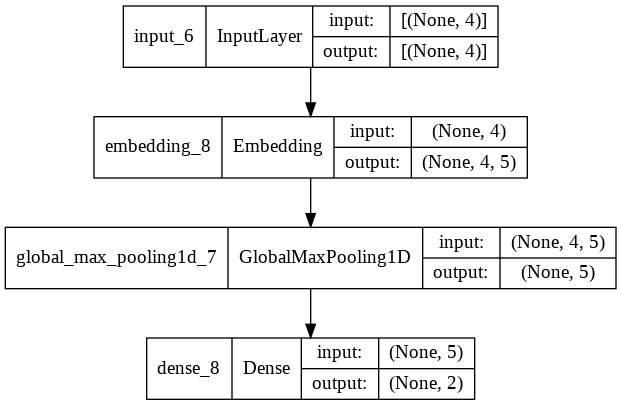

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
save_weights = tf.keras.callbacks.ModelCheckpoint("sentence_calss.hdf5",
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger("sentence_calss.csv")

In [ ]:
# 모델 학습
history = model.fit(train_inputs, train_labels,
                    epochs=100,
                    batch_size=16,
                    validation_data=(valid_inputs, valid_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.5000
Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to sentence_calss.hdf5
1/1 [==============================] - 1s 555ms/step - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.6836 - val_accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.5000
Epoch 00002: val_accuracy did not improve from 1.00000
1/1 [==============================] - 0s 30ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6848 - val_accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5000
Epoch 00003: val_accuracy did not improve from 1.00000
1/1 [==============================] - 0s 26ms/step - loss: 0.6921 - accuracy: 0.5000 - val_loss: 0.6860 - val_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.5000
Epoch 00004: val_accuracy did not improv

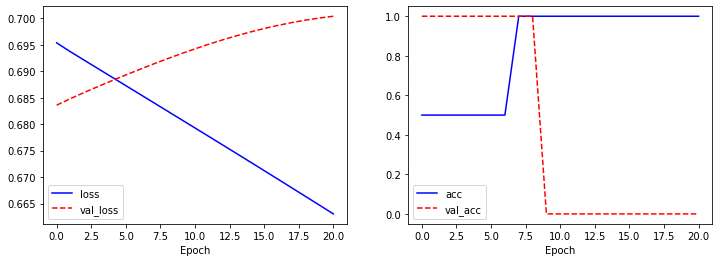

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b-', label='acc')
plt.plot(history.history['val_accuracy'], 'r--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# 6.평가

In [ ]:
model = build_model(args)
model.load_weights("sentence_calss.hdf5")

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# 모델 평가
model.evaluate(test_inputs, test_labels)

1/1 [==============================] - 0s 202ms/step - loss: 0.7256 - accuracy: 0.0000e+00


[0.725557804107666, 0.0]

# 7.배포

In [ ]:
model = build_model(args)
model.load_weights("sentence_calss.hdf5")

In [ ]:
# 추론할 입력
string = '신차 정말 디자인 엉터리로'

In [ ]:
# 입력을 숫자로 변경
infer_input = [word_to_id[word] for word in string.split()]
infer_input

[2, 3, 8, 10]

In [ ]:
# numpy array 변환
infer_inputs = np.array([infer_input])
infer_inputs

array([[ 2,  3,  8, 10]])

In [ ]:
# 부정(0), 긍정(1) 추론
y_preds = model.predict(infer_inputs)
y_preds

array([[0.5020876 , 0.49791244]], dtype=float32)

In [ ]:
# 확률의 max 값을 추론 값으로 결정
y_pred_class = np.argmax(y_preds, axis=1)
y_pred_class

array([0])

In [ ]:
id_to_label = {0: '부정', 1: '긍정'}

In [ ]:
# 각 예측 값에 대한 label string
for val in y_pred_class:
    print(id_to_label[val])

부정


In [ ]:
def do_predict(word_to_id, id_to_label, model, string):
    tokens = string.split()[:4]
    # 입력을 숫자로 변경
    infer_input = [word_to_id.get(word, 1) for word in tokens]
    print(infer_input)
    # numpy array 변환
    infer_input += [0] * (4 - len(infer_input))
    infer_inputs = np.array([infer_input])
    print(infer_inputs)
    # 부정(0), 긍정(1) 추론
    y_preds = model.predict(infer_inputs)
    print(y_preds)
    # 확률의 max 값을 추론 값으로 결정
    y_pred_class = np.argmax(y_preds, axis=-1)[0]
    print(y_pred_class)
    # print(tokens)
    return id_to_label[y_pred_class]

In [ ]:
do_predict(word_to_id, id_to_label, model, string)

[2, 3, 8, 10]
[[ 2  3  8 10]]
[[0.5020876  0.49791244]]
0


'부정'

In [ ]:
# 신차 연비 좋아요, 엉터리로 개발했네요 등
while True:
    print('input >> ', end='')
    string = input()
    string = string.strip()
    if not string:
        break
    result = do_predict(word_to_id, id_to_label, model, string)
    print(result)

input >> 신차 연비 좋아요
[2, 9, 4]
[[2 9 4 0]]
[[0.49353707 0.50646293]]
1
긍정
input >> 엉터리로 개발했네요
[10, 11]
[[10 11  0  0]]
[[0.48270682 0.5172932 ]]
1
긍정
input >> 
